In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/'

Mounted at /content/drive


[OPTIONAL] Extract .zip Dataset

In [ ]:
import os
import zipfile

zip_file_path = '/content/drive/My Drive/Dataset6.zip'
extract_path_drive = '/content/drive/My Drive/'

os.makedirs(extract_path_drive, exist_ok=True)

print(f"Attempting to extract {zip_file_path} to {extract_path_drive}")

!unzip -o -q "{zip_file_path}" -d "{extract_path_drive}"

print("\nExtraction complete!")

Attempting to extract /content/drive/My Drive/Dataset6.zip to /content/drive/My Drive/

Extraction complete!


In [ ]:
!pip install -q -U albumentations

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from collections import defaultdict


[OPTIONAL] Dataset Size Verification

In [ ]:
root_path = '/content/drive/MyDrive/Dataset6/' #CHANGE PATH

for subfolder in os.listdir(root_path):
    full_path = os.path.join(root_path, subfolder)
    if os.path.isdir(full_path):
        count = sum([len(files) for _, _, files in os.walk(full_path)])
        print(f"{subfolder}: {count} images")


test: 180 images
train: 420 images
valid: 180 images


Image Preprocessing (Albumentations)

--- Visualizing a Sample Before and After Augmentation ---


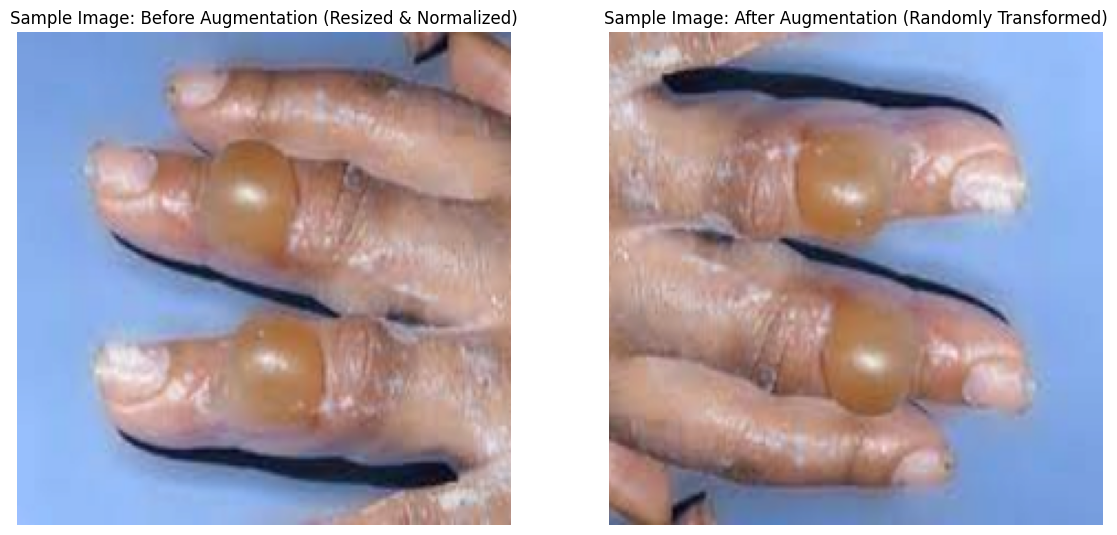


--- Image Counts in Each Dataset ---
Original (non-augmented) count for train folder: 420 samples
Total number of samples in the FINAL training dataset (Original + Augmented versions): 840 samples
Count for validation set: 180 samples
Count for test set: 180 samples


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Ensures ImageFolder works well
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

# Define the Albumentations transformations (from your code)
import albumentations as A
from albumentations.pytorch import ToTensorV2

size = 224

train_transform = A.Compose([
    A.Resize(size, size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

original_image_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_val_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Custom Dataset class (from your code)
class AlbumentationsDataset(Dataset):
    def __init__(self, folder_path, transform=None, original_transform=None, augment_factor=1):
        self.dataset = ImageFolder(folder_path)
        self.transform = transform
        # If original_transform is not provided, use test_val_transform as a sensible default
        self.original_transform = original_transform if original_transform else test_val_transform
        self.augment_factor = augment_factor # How many augmented versions per original

    def __len__(self):
        return len(self.dataset) * (1 + self.augment_factor)

    def __getitem__(self, idx):
        original_idx = idx // (1 + self.augment_factor)
        version_type = idx % (1 + self.augment_factor) # 0 for original, 1 to augment_factor for augmented

        path, label = self.dataset.samples[original_idx]
        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(f"Image not found or corrupted at path: {path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if version_type == 0: # This is the original image (base-transformed)
            if self.original_transform:
                processed_image = self.original_transform(image=image)['image']
            else:
                # Fallback, though original_transform is now set in __init__
                processed_image = image
            return processed_image, label
        else: # This is an augmented version
            if self.transform:
                processed_image = self.transform(image=image)['image']
            else:
                raise ValueError("Augmentation transform not provided for augmented versions.")
            return processed_image, label

# Base path for your dataset
base_path = '/content/drive/MyDrive/Dataset6'

# --- Dataset and DataLoader initialization (as in your code) ---
train_dataset = AlbumentationsDataset(
    os.path.join(base_path, 'train'),
    transform=train_transform,
    original_transform=original_image_transform,
    augment_factor=1
)
val_dataset   = AlbumentationsDataset(os.path.join(base_path, 'valid'), transform=test_val_transform, augment_factor=0)
test_dataset  = AlbumentationsDataset(os.path.join(base_path, 'test'),  transform=test_val_transform, augment_factor=0)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- Denormalization function for visualization ---
def denormalize(tensor_image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = tensor_image * std + mean
    img = img.permute(1, 2, 0).cpu().numpy() # Convert C, H, W to H, W, C and to NumPy
    img = np.clip(img * 255, 0, 255).astype(np.uint8) # Scale to 0-255 and convert to uint8
    return img

# --- Visualize a random image before and after augmentation ---
print("--- Visualizing a Sample Before and After Augmentation ---")
try:
    temp_original_dataset = ImageFolder(os.path.join(base_path, 'train'))
    if len(temp_original_dataset) == 0:
        print(f"Error: No images found in '{os.path.join(base_path, 'train')}'. Cannot visualize.")
    else:
        import random
        random_idx = random.randint(0, len(temp_original_dataset) - 1)
        sample_image_path, _ = temp_original_dataset.samples[random_idx]

        # Load the original image (raw, non-transformed)
        original_image_np = cv2.imread(sample_image_path)
        if original_image_np is None:
            raise FileNotFoundError(f"Could not load image from {sample_image_path}")
        original_image_np = cv2.cvtColor(original_image_np, cv2.COLOR_BGR2RGB) # Convert to RGB

        # Apply the "original_image_transform" to get the 'before' version (resized and normalized)
        before_augmentation_tensor = original_image_transform(image=original_image_np)['image']

        # Apply the "train_transform" to get one instance of the 'after' augmented version
        after_augmentation_tensor = train_transform(image=original_image_np)['image']

        # Denormalize images for display
        before_display = denormalize(before_augmentation_tensor)
        after_display = denormalize(after_augmentation_tensor)

        # Plotting
        plt.figure(figsize=(14, 7))

        plt.subplot(1, 2, 1)
        plt.imshow(before_display)
        plt.title('Sample Image: Before Augmentation (Resized & Normalized)')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(after_display)
        plt.title('Sample Image: After Augmentation (Randomly Transformed)')
        plt.axis('off')

        plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset path and image files are correct and accessible.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please check your environment setup (e.g., albumentations, torchvision, opencv-python, matplotlib installed).")


print("\n--- Image Counts in Each Dataset ---")
if os.path.exists(os.path.join(base_path, 'train')):
    original_train_count = len(ImageFolder(os.path.join(base_path, 'train')))
    print(f"Original (non-augmented) count for train folder: {original_train_count} samples")
    print(f"Total number of samples in the FINAL training dataset (Original + Augmented versions): {len(train_dataset)} samples")
else:
    print(f"Train folder '{os.path.join(base_path, 'train')}' not found. Cannot determine original train count.")

if os.path.exists(os.path.join(base_path, 'valid')):
    print(f"Count for validation set: {len(val_dataset)} samples")
else:
    print(f"Validation folder '{os.path.join(base_path, 'valid')}' not found.")

if os.path.exists(os.path.join(base_path, 'test')):
    print(f"Count for test set: {len(test_dataset)} samples")
else:
    print(f"Test folder '{os.path.join(base_path, 'test')}' not found.")

Build Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import os
from tqdm import tqdm

class BurnClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        self.features = mobilenet.features
        feature_channels = 960

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Global average pooling to flatten features
            nn.Flatten(),             # Flatten the output for linear layers

            # Layer 1
            nn.Linear(feature_channels, 512), # From 960 features to 512
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.4),               # Increased dropout for regularization

            # Layer 2 (Hidden Layer)
            nn.Linear(512, 256),           # From 512 to 256
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.3),               # Dropout

            # Layer 3
            nn.Linear(256, 128),           # From 256 to 128
            nn.SiLU(),
            nn.Dropout(0.2),

            # Output Layer
            nn.Linear(128, num_classes)    # Final layer mapping to the 3 burn classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping: {self.counter}/{self.patience} without improvement.")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"✅ Validation loss decreased ({self.val_loss_min:.4f} → {val_loss:.4f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

TRAINING LOOP


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BurnClassifier(num_classes=3).to(device)
EPOCHS = 30

# Optimization
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader), eta_min=1e-6)

# Loss Function
criterion = nn.CrossEntropyLoss()
# class_weights = torch.tensor([1.0, 1.5, 1.8]).to(device) # Example weights, tune these!
# criterion = nn.CrossEntropyLoss(weight=class_weights)

model_save_path = '/content/drive/MyDrive/final1.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

early_stopping = EarlyStopping(
    patience=7,
    verbose=True,
    delta=0.0005,
    path=model_save_path
)


# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0

    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix({
            'Batch Loss': f"{loss.item():.4f}",
            'Epoch Loss': f"{train_loss/(batch_idx+1):.4f}",
            'Accuracy': f"{100*correct/total:.2f}%"
        })

    # Validation after each epoch
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"📉 Validation Loss: {val_loss:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Loading best model...")
        model.load_state_dict(torch.load(early_stopping.path))
        break # Exit the training loop

print(f"✅ Training finished. Best model weights saved to: {model_save_path}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 162MB/s]
Epoch [1/30]: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s, Batch Loss=1.0029, Epoch Loss=1.0699, Accuracy=49.88%]


📉 Validation Loss: 1.0224
✅ Validation loss decreased (inf → 1.0224). Saving model ...


Epoch [2/30]: 100%|██████████| 27/27 [00:06<00:00,  4.42it/s, Batch Loss=0.5792, Epoch Loss=0.7897, Accuracy=81.55%]


📉 Validation Loss: 1.3520
⏳ EarlyStopping: 1/7 without improvement.


Epoch [3/30]: 100%|██████████| 27/27 [00:05<00:00,  4.62it/s, Batch Loss=0.1758, Epoch Loss=0.3426, Accuracy=90.71%]


📉 Validation Loss: 1.2956
⏳ EarlyStopping: 2/7 without improvement.


Epoch [4/30]: 100%|██████████| 27/27 [00:06<00:00,  3.90it/s, Batch Loss=0.0712, Epoch Loss=0.1327, Accuracy=95.36%]


📉 Validation Loss: 0.8548
✅ Validation loss decreased (1.0224 → 0.8548). Saving model ...


Epoch [5/30]: 100%|██████████| 27/27 [00:05<00:00,  4.74it/s, Batch Loss=1.4604, Epoch Loss=0.1282, Accuracy=97.50%]


📉 Validation Loss: 0.8595
⏳ EarlyStopping: 1/7 without improvement.


Epoch [6/30]: 100%|██████████| 27/27 [00:07<00:00,  3.70it/s, Batch Loss=0.0126, Epoch Loss=0.0603, Accuracy=97.86%]


📉 Validation Loss: 0.5522
✅ Validation loss decreased (0.8548 → 0.5522). Saving model ...


Epoch [7/30]: 100%|██████████| 27/27 [00:05<00:00,  4.79it/s, Batch Loss=0.0032, Epoch Loss=0.0363, Accuracy=98.69%]


📉 Validation Loss: 0.5688
⏳ EarlyStopping: 1/7 without improvement.


Epoch [8/30]: 100%|██████████| 27/27 [00:06<00:00,  4.10it/s, Batch Loss=0.0015, Epoch Loss=0.0342, Accuracy=98.93%]


📉 Validation Loss: 0.5352
✅ Validation loss decreased (0.5522 → 0.5352). Saving model ...


Epoch [9/30]: 100%|██████████| 27/27 [00:06<00:00,  4.46it/s, Batch Loss=0.0036, Epoch Loss=0.0326, Accuracy=99.29%]


📉 Validation Loss: 0.4456
✅ Validation loss decreased (0.5352 → 0.4456). Saving model ...


Epoch [10/30]: 100%|██████████| 27/27 [00:05<00:00,  4.81it/s, Batch Loss=0.0126, Epoch Loss=0.0374, Accuracy=98.81%]


📉 Validation Loss: 0.4168
✅ Validation loss decreased (0.4456 → 0.4168). Saving model ...


Epoch [11/30]: 100%|██████████| 27/27 [00:06<00:00,  4.03it/s, Batch Loss=0.0011, Epoch Loss=0.0210, Accuracy=99.17%]


📉 Validation Loss: 0.4207
⏳ EarlyStopping: 1/7 without improvement.


Epoch [12/30]: 100%|██████████| 27/27 [00:05<00:00,  4.58it/s, Batch Loss=0.0009, Epoch Loss=0.0267, Accuracy=98.93%]


📉 Validation Loss: 0.4023
✅ Validation loss decreased (0.4168 → 0.4023). Saving model ...


Epoch [13/30]: 100%|██████████| 27/27 [00:06<00:00,  3.98it/s, Batch Loss=0.5648, Epoch Loss=0.0482, Accuracy=99.29%]


📉 Validation Loss: 0.3775
✅ Validation loss decreased (0.4023 → 0.3775). Saving model ...


Epoch [14/30]: 100%|██████████| 27/27 [00:05<00:00,  4.76it/s, Batch Loss=0.2850, Epoch Loss=0.0456, Accuracy=98.21%]


📉 Validation Loss: 0.5256
⏳ EarlyStopping: 1/7 without improvement.


Epoch [15/30]: 100%|██████████| 27/27 [00:06<00:00,  3.93it/s, Batch Loss=0.5092, Epoch Loss=0.0577, Accuracy=98.93%]


📉 Validation Loss: 0.4752
⏳ EarlyStopping: 2/7 without improvement.


Epoch [16/30]: 100%|██████████| 27/27 [00:05<00:00,  4.51it/s, Batch Loss=0.1569, Epoch Loss=0.0335, Accuracy=99.05%]


📉 Validation Loss: 0.5338
⏳ EarlyStopping: 3/7 without improvement.


Epoch [17/30]: 100%|██████████| 27/27 [00:05<00:00,  4.64it/s, Batch Loss=0.0306, Epoch Loss=0.0284, Accuracy=98.69%]


📉 Validation Loss: 0.3786
⏳ EarlyStopping: 4/7 without improvement.


Epoch [18/30]: 100%|██████████| 27/27 [00:06<00:00,  3.98it/s, Batch Loss=0.0952, Epoch Loss=0.0233, Accuracy=99.05%]


📉 Validation Loss: 0.3489
✅ Validation loss decreased (0.3775 → 0.3489). Saving model ...


Epoch [19/30]: 100%|██████████| 27/27 [00:05<00:00,  4.74it/s, Batch Loss=0.0077, Epoch Loss=0.0247, Accuracy=99.40%]


📉 Validation Loss: 0.3313
✅ Validation loss decreased (0.3489 → 0.3313). Saving model ...


Epoch [20/30]: 100%|██████████| 27/27 [00:06<00:00,  3.95it/s, Batch Loss=0.0034, Epoch Loss=0.0192, Accuracy=99.40%]


📉 Validation Loss: 0.3300
✅ Validation loss decreased (0.3313 → 0.3300). Saving model ...


Epoch [21/30]: 100%|██████████| 27/27 [00:05<00:00,  4.75it/s, Batch Loss=0.0006, Epoch Loss=0.0102, Accuracy=99.64%]


📉 Validation Loss: 0.3454
⏳ EarlyStopping: 1/7 without improvement.


Epoch [22/30]: 100%|██████████| 27/27 [00:06<00:00,  4.01it/s, Batch Loss=0.0109, Epoch Loss=0.0127, Accuracy=99.64%]


📉 Validation Loss: 0.3412
⏳ EarlyStopping: 2/7 without improvement.


Epoch [23/30]: 100%|██████████| 27/27 [00:05<00:00,  4.50it/s, Batch Loss=0.0540, Epoch Loss=0.0219, Accuracy=99.40%]


📉 Validation Loss: 0.3180
✅ Validation loss decreased (0.3300 → 0.3180). Saving model ...


Epoch [24/30]: 100%|██████████| 27/27 [00:05<00:00,  4.60it/s, Batch Loss=0.0099, Epoch Loss=0.0123, Accuracy=99.64%]


📉 Validation Loss: 0.3177
⏳ EarlyStopping: 1/7 without improvement.


Epoch [25/30]: 100%|██████████| 27/27 [00:07<00:00,  3.83it/s, Batch Loss=0.0030, Epoch Loss=0.0116, Accuracy=99.64%]


📉 Validation Loss: 0.3199
⏳ EarlyStopping: 2/7 without improvement.


Epoch [26/30]: 100%|██████████| 27/27 [00:05<00:00,  4.92it/s, Batch Loss=0.4716, Epoch Loss=0.0386, Accuracy=99.29%]


📉 Validation Loss: 0.3194
⏳ EarlyStopping: 3/7 without improvement.


Epoch [27/30]: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, Batch Loss=0.1077, Epoch Loss=0.0183, Accuracy=99.40%]


📉 Validation Loss: 0.3280
⏳ EarlyStopping: 4/7 without improvement.


Epoch [28/30]: 100%|██████████| 27/27 [00:05<00:00,  4.66it/s, Batch Loss=0.0013, Epoch Loss=0.0140, Accuracy=99.29%]


📉 Validation Loss: 0.3260
⏳ EarlyStopping: 5/7 without improvement.


Epoch [29/30]: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, Batch Loss=0.2716, Epoch Loss=0.0234, Accuracy=99.29%]


📉 Validation Loss: 0.3233
⏳ EarlyStopping: 6/7 without improvement.


Epoch [30/30]: 100%|██████████| 27/27 [00:05<00:00,  4.87it/s, Batch Loss=0.4477, Epoch Loss=0.0241, Accuracy=99.64%]


📉 Validation Loss: 0.3225
⏳ EarlyStopping: 7/7 without improvement.
Early stopping triggered. Loading best model...
✅ Training finished. Best model weights saved to: /content/drive/MyDrive/final1.pth


Evaluation Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


model.eval()

# Evaluation on Test Set
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = test_dataset.dataset.classes

print("\nClassification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix for BurnClassifier Model (Augmented + Multilayered Head):")
print(confusion_matrix(y_true, y_pred))


Classification Report on Test Set:
              precision    recall  f1-score   support

  1st degree       0.94      0.85      0.89        60
  2nd degree       0.81      0.90      0.85        60
  3rd degree       0.93      0.92      0.92        60

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180


Confusion Matrix for BurnClassifier Model (Augmented + Multilayered Head):
[[51  9  0]
 [ 2 54  4]
 [ 1  4 55]]


In [ ]:
import torch
import cv2
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# Load TorchScript model
model = torch.jit.load("/content/drive/MyDrive/burnaidmodel.pt")
model.eval()

# Define transforms matching your test_val_transform
transform = Compose([
    Resize(224, 224),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Load image
img = cv2.imread("/content/14.jpeg")  # Replace with actual image name
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply transform
transformed = transform(image=img)["image"]
input_tensor = transformed.unsqueeze(0)  # Add batch dimension [1, 3, 224, 224]

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1)
    print("Predicted class:", pred.item())
    print("Raw logits:", output.tolist())


Predicted class: 0
Raw logits: [[6.122982978820801, -0.09996981173753738, -5.133824348449707]]


[IMP] Export Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile
import os
import collections

class BurnClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        self.features = mobilenet.features
        feature_channels = 960

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            # Layer 1
            nn.Linear(feature_channels, 512), # From 960 features to 512
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.4),               # Increased dropout for regularization

            # Layer 2 (Hidden Layer)
            nn.Linear(512, 256),           # From 512 to 256
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.3),               # Dropout

            # Layer 3
            nn.Linear(256, 128),           # From 256 to 128
            nn.SiLU(),
            nn.Dropout(0.2),

            # Output Layer
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- Configuration for Model Optimization ---
original_state_dict_path = '/content/drive/MyDrive/final1.pth' #CHANGE FILE NAME
output_model_name = 'burnaidmodel.pt'
output_dir = '/content/drive/MyDrive/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
output_model_full_path = os.path.join(output_dir, output_model_name)

print(f"Starting model optimization for CPU inference...")

#  Model Instantiation and Loading
try:
    model = BurnClassifier(num_classes=3)
    state_dict = torch.load(original_state_dict_path, map_location=torch.device('cpu'))

    model.load_state_dict(state_dict)
    model.eval() # Set to evaluation mode
    print("Original model loaded successfully onto CPU from state_dict.")
except Exception as e:
    print(f"Error instantiating or loading state_dict into model from {original_state_dict_path}: {e}")
    print("Please ensure your 'BurnClassifier' class definition in this script is IDENTICAL to the one used for saving the model.")
    exit()

# Trace the model to TorchScript
dummy_input = torch.rand(1, 3, 224, 224).to(torch.device('cpu'))
print(f"Created dummy input of shape: {dummy_input.shape} on device: {dummy_input.device}")

traced_model = None
try:
    # Use torch.jit.trace for models that do not use data-dependent control flow
    traced_model = torch.jit.trace(model, dummy_input)
    print("Model traced successfully to TorchScript.")
except Exception as e:
    print(f"Error tracing model: {e}")
    print("If your model uses data-dependent control flow (e.g., if/else based on input values), tracing might fail.")
    print("Attempting torch.jit.script instead (for models with control flow)...")
    try:
        # Use torch.jit.script for models with control flow.
        traced_model = torch.jit.script(model)
        print("Model scripted successfully to TorchScript.")
    except Exception as e:
        print(f"Could not trace or script the model: {e}")
        print("Please review your model's architecture and PyTorch documentation for TorchScript conversion.")
        exit()

# Optimize the TorchScript model for mobile (CPU backend)
try:
    optimized_model = optimize_for_mobile(traced_model)
    print("Model optimized for mobile (CPU backend).")
except Exception as e:
    print(f"Error optimizing model for mobile: {e}")
    print("Ensure your PyTorch version is up-to-date and torch.utils.mobile_optimizer is available.")
    exit()

# Save the model in the Lite Interpreter format (.ptl)
try:
    optimized_model._save_for_lite_interpreter(output_model_full_path)
    print(f"Optimized model successfully saved to: {output_model_full_path}")
except Exception as e:
    print(f"Error saving optimized model to {output_model_full_path}: {e}")
    print("Please check write permissions for the output directory or available disk space.")
    exit()

print("\nModel optimization complete.")
print("The 'burnaidmodel.pt' file is ready for integration into your mobile application.")
print("Remember to place it in your Flutter project's 'assets/models/' folder or equivalent.")


Starting model optimization for CPU inference...
Original model loaded successfully onto CPU from state_dict.
Created dummy input of shape: torch.Size([1, 3, 224, 224]) on device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model traced successfully to TorchScript.
Model optimized for mobile (CPU backend).
Optimized model successfully saved to: /content/drive/MyDrive/burnaidmodel.pt

Model optimization complete.
The 'burnaidmodel.pt' file is ready for integration into your mobile application.
Remember to place it in your Flutter project's 'assets/models/' folder or equivalent.
